In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [518]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
    """
    def __init__(self, num_iter, lr, bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        self.theta = 0
        self.theta_arr = []
        
        self.slambda = 0
        self.threshold_value = 0.5 #  閾値
        
    def fit(self, X, y, X_val=None, y_val=None, slambda = 0.5):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """

        # ラムダ
        self.slambda = slambda
        
        # 検証データフラグ
        if X_val is None:
            is_exists = False
        else:
            is_exists = True
            # バイアス
            X_val = self._add_bias(X_val)
        
        # バイアス
        X = self._add_bias(X)
            
        # 最急降下法(訓練データ)
        self._gradient_descent(X, y, True)
        
        # 最急降下法(検証データ)
        if is_exists:
            self._gradient_descent(X_val, y_val, False)
        
        # 学習結果を出力
        if self.verbose:
            
            plt.plot(np.arange(self.iter), self.loss)
            
            if is_exists:
                plt.plot(np.arange(self.iter), self.val_loss)
            
    def _gradient_descent(self, X, y, is_train):
        
        # j_theta, theta を記録する配列
        min_j_theta = 0
        min_theta = 0
        tmp_theta = 0
        
        # 特徴量の数だけランダムな値シータを生成
        tmp_theta = np.random.rand(X.shape[1])
        
        # 最急降下法
        for i in range(self.iter):
        
            # 仮定関数より予測値を算出
            y_hat = self._linear_hypothesis(X, tmp_theta)
            
            # トレインデータの場合
            # 最急降下法を用いてパラメータを更新
            if is_train:

                if self.no_bias:
                    # パラメータの更新
                    tmp_theta = tmp_theta - self.lr * (np.dot(X.T, (y_hat - y)) + (self.slambda*tmp_theta))/len(X)
                else:
                    # パラメータの更新
                    tmp_theta[0] = tmp_theta[0] - self.lr * np.dot(X[:,0].T, (y_hat - y)) /len(X)
                    tmp_theta[1:] = tmp_theta[1:] - self.lr * (np.dot(X[:,1].T, (y_hat - y)) + (self.slambda*tmp_theta[1:]))/len(X)
                
                self.theta_arr.append(tmp_theta.copy())

                # 検証データの場合
                # トレインデータで算出したパラメータを使用
            else:
                tmp_theta = self.theta_arr[i]
            
            # 仮定関数より予測値を算出
            y_hat = self._linear_hypothesis(X, tmp_theta)
            
            # 目的関数（損失関数）にて損失を算出
            j_theta = self._loss(y_hat, y, tmp_theta)
            
            if is_train:
                # 目的関数（損失関数）を記録
                self.loss[i] = j_theta
                
                # 最小になる損失関数を保持
                if i == 0 or j_theta < min_j_theta:
                    min_j_theta = j_theta
                    min_theta = tmp_theta
            else:
                # 目的関数（損失関数）を記録
                self.val_loss[i] = j_theta
            
        if is_train:
            # シータの学習結果を設定
            self.theta = min_theta
            
    # 仮定関数 
    def _linear_hypothesis(self, X, theta):
        
        # 線型結合の仮定関数
        z = np.dot(X, theta.T)
        
        # シグモイド関数にzを入力
        y_hat = 1 / (1 + np.exp(-z))
        
        return y_hat
    
    # 損失関数
    def _loss(self, h, y, theta):
        
        # 正則化項
        rg = np.mean(theta**2) * (self.slambda / 2*y.size)
        
        loss = np.mean((-y * np.log(h) - (1 - y) * np.log(1 - h)))
    
        return loss + rg
    
    def _add_bias(self, X):
        
        if self.no_bias:
            pass
        else:
            X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        
        return X

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        return np.where(self.predict_proba(X) < self.threshold_value, 0, 1)
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        X = self._add_bias(X)
        return self._linear_hypothesis(X, self.theta)

In [595]:
# データのロード
from sklearn import datasets

iris_dataset = datasets.load_iris()
X = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
y = pd.DataFrame(iris_dataset.target, columns=["Species"])

df = pd.concat([X, y], axis=1)
df = df.loc[:,["sepal_length","petal_length","Species"]]
df = df[df["Species"].isin(['1','2'])]

X = df.loc[:, ["sepal_length","petal_length"]].values
y = df.loc[:, ["Species"]].replace(2,0).values
y = np.reshape(y,[y.shape[0],])

# データセットの分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

【問題5】学習と推定
【問題6】学習曲線のプロット

predict [0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0]
predict_proba [0.45686898 0.52204968 0.52691866 0.50626332 0.50765287 0.58129454
 0.4902329  0.46079633 0.51276305 0.48163666 0.48813281 0.56743027
 0.5322439  0.53779212 0.49673389 0.45709891 0.5160196  0.47676443
 0.45617933 0.44077721 0.54679354 0.47097309 0.49673389 0.50672651
 0.42526177]


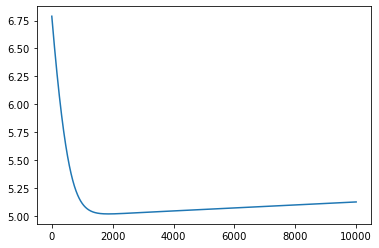

In [603]:
# スクラッチ(訓練データ)
scr_lr = ScratchLogisticRegression(10000, 0.0001, False, True)
scr_lr.fit(X_train, y_train)

print("predict",scr_lr.predict(X_test))
print("predict_proba",scr_lr.predict_proba(X_test))

predict [0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0]
predict_proba [0.46135428 0.49942168 0.50470447 0.50265627 0.47976727 0.53983216
 0.50970637 0.48183469 0.48123129 0.4800689  0.45871868 0.51642868
 0.50235416 0.49618714 0.48827591 0.45756271 0.51321907 0.47479678
 0.4727541  0.4721738  0.51819492 0.48476391 0.48827591 0.4950231
 0.47539951]


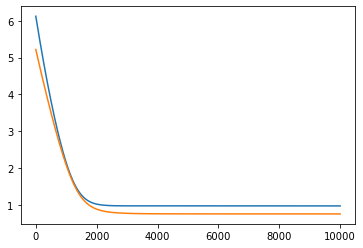

In [621]:
# スクラッチ(訓練データ＋検証データ)
scr_lr2 = ScratchLogisticRegression(10000, 0.0001, False, True)
scr_lr2.fit(X_train, y_train, X_val, y_val)

print("predict",scr_lr2.predict(X_test))
print("predict_proba",scr_lr2.predict_proba(X_test))

In [605]:
# 本家
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(Y_pred)

[0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


In [606]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
scr_y_pred = scr_lr.predict(X_test)
Y_pred = clf.predict(X_test)

def pri(y_test, Y_pred):
    print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=Y_pred))
    print('accuracy = ', accuracy_score(y_true=y_test, y_pred=Y_pred))
    print('precision = ', precision_score(y_true=y_test, y_pred=Y_pred))
    print('recall = ', recall_score(y_true=y_test, y_pred=Y_pred))
    print('f1 score = ', f1_score(y_true=y_test, y_pred=Y_pred))

print("スクラッチ")
pri(y_test, scr_y_pred)
print("本家")
pri(y_test, y_pred)
    

スクラッチ
confusion matrix = 
 [[10  0]
 [ 3 12]]
accuracy =  0.88
precision =  1.0
recall =  0.8
f1 score =  0.888888888888889
本家
confusion matrix = 
 [[ 3  7]
 [ 0 15]]
accuracy =  0.72
precision =  0.6818181818181818
recall =  1.0
f1 score =  0.8108108108108109


【問題7】決定領域の可視化

In [607]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# 決定領域のプロット
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元にグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # クラス毎にサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

    # テストサンプルを目立たせる
    if test_idx:
        # すべてのサンプルをプロット
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

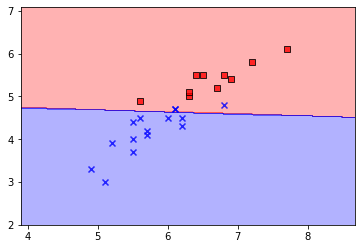

In [608]:
# スクラッチ
plot_decision_regions(X_test, y_test, scr_lr)

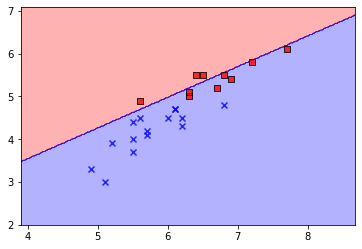

In [609]:
# 本家
plot_decision_regions(X_test, y_test, clf)